In [199]:
import pandas as pd
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from scipy import stats
from wordcloud import WordCloud
import seaborn as sns
import warnings

#text preprocess libs
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup as bs
import string
from nltk.stem import SnowballStemmer
import contractions

#models
import gensim.downloader as api
from gensim import corpora
from gensim.models import Word2Vec, FastText, TfidfModel, phrases
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score, roc_curve, precision_recall_curve, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('takehome.csv')

In [9]:
df['id'] = np.arange(len(df))
df['sentiment'] = np.where(df['label'] == 'neg', 0, 1)
df['length'] = df['review'].apply(lambda x: len(x.split()))
df = df[['id', 'review','label', 'sentiment', 'length']]
df.head()

,id,review,label,sentiment,length
0,0,This failed exercise in satire or commentary o...,neg,0,257
1,1,"Donald Sutherland, an American paleontologist ...",neg,0,380
2,2,JP3 lacks the Spielberg touch. It's an all-out...,neg,0,161
3,3,It's a shame. There's an interesting idea here...,neg,0,114
4,4,Naked Deanna Troi! <br /><br />Richie's brothe...,neg,0,162


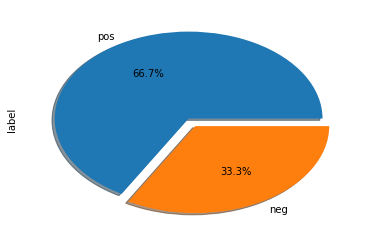

In [6]:
df['label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True)

We see that there are twice as many positive reviews as negative reviews so we should be sure to evaluate the precision and F1 score for predicting negative reviews

Possible Preprocessing Steps

1. Remove html markups 
2. Remove stopwords
3. Lemmatize words 
4. Remove punctuation and special character (excluding # and $)
5. Bigram or trigram detection. 

The following class is written to preproces the data by providing arguments for lemmatization, stop word removal, and phrase detection. Because phrase models are usually trained over the whole corpus and we don't want to leak any data from the training to the test set, I have elected not to use a phrase detection model for this exercise.


In [82]:

class CleanData:
    
    def __init__(self, dataset):
        self.dataset = dataset

    def makedf(self, sw = True, lemmatize = True):
        if lemmatize:
            snowball_stemmer = SnowballStemmer('english')
        clean = []
        letters = list('abcdefghijklmnopqrstuvwxyz')
        stop = set(stopwords.words('english'))
        if sw:
            stop_words = stop.union(set(letters))
        else:
            stop_words = []
        filtered = ''.join(i for i in string.punctuation if i != '$' and i != '#')    
        punc  = re.compile('([%s])+' % re.escape(filtered), re.UNICODE) 
        for i in self.dataset.itertuples():
            text = bs(i[2], 'lxml').get_text()
            text = punc.sub(' ', text)
            if lemmatize:
                text = [snowball_stemmer.stem(w) for w in text.lower().split() if w not in stop_words and not w.startswith('https') and not w.isdigit()]
            else:
                 text = [w for w in text.lower().split() if w not in stop_words and not w.startswith('https') and not w.isdigit()]
            length = len(text)
            text = ' '.join(i for i in text)
            text = contractions.fix(text)
            clean.append([i[1], text, i[4], length])
        clean = pd.DataFrame(clean)
        clean.columns = ['id', 'text', 'label', 'length']
        return clean

    def getphrases(self, data, min_count, threshold):
        bigram = phrases.Phrases(list(data['text']), min_count = min_count, threshold = threshold)
        return bigram

    def preprocessed(self, data, phraser, phrases = True, doc2vec = False):
        corpus = []
        buzz_map = {}
        if phrases:
            for i in data.itertuples():
                text = phraser[i[2]]
                text = ' '.join(i for i in text)
                data.set_value(i[0],'text',text)
        else:
            for i in data.itertuples():
                text = i[2]
                text = ' '.join(i for i in text)
                data.set_value(i[0],'text',text)
        return data

In [83]:
clean = CleanData(df)
cleaned_sw_lem = clean.makedf(sw = False, lemmatize = False)
cleaned_x_sw_x_lem = clean.makedf()
cleaned_x_sw = clean.makedf(lemmatize = False)

Text(0.5,1,'length of review w/o stop words, mean length 117.368')

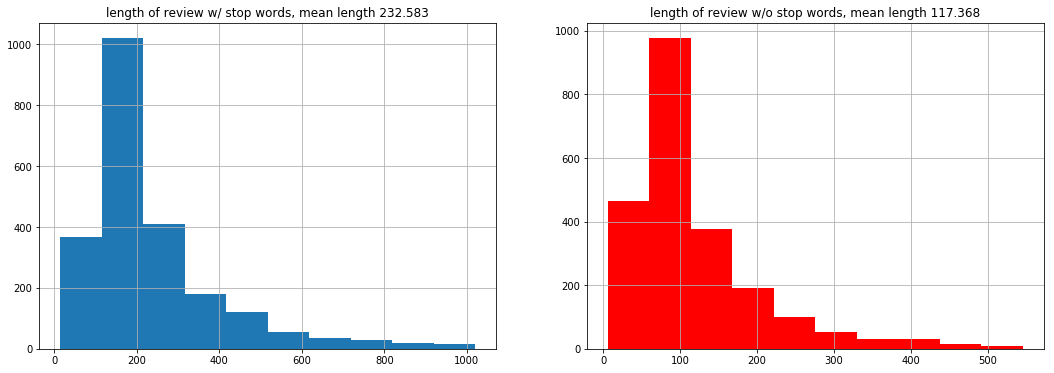

In [105]:
f,ax=plt.subplots(1,2,figsize=(18,6))
cleaned_sw_lem['length'].hist(ax = ax[0])
cleaned_x_sw['length'].hist(ax = ax[1], color = 'r')
sw = "%.3f" % np.mean(cleaned_sw_lem['length'])
x_sw = "%.3f" % np.mean(cleaned_x_sw['length'])
ax[0].set_title('length of review w/ stop words, mean length {}'.format(sw))
ax[1].set_title('length of review w/o stop words, mean length {}'.format(x_sw))

The average length of a reviews is 232.6 words with no stop words removed, without stop words the lenght of the review is 117.4 words on average. The distribution of review length is skewed. In order to gain an undertanding of the words that made up positive and negative reviews, word clouds were created for both classes. Unfortunately but not unexpectedly, both positive and negative reviews share commonly occuring words such as "film", "movie", and "one". To get a better picture, the common occurring words between both classes were filtered out

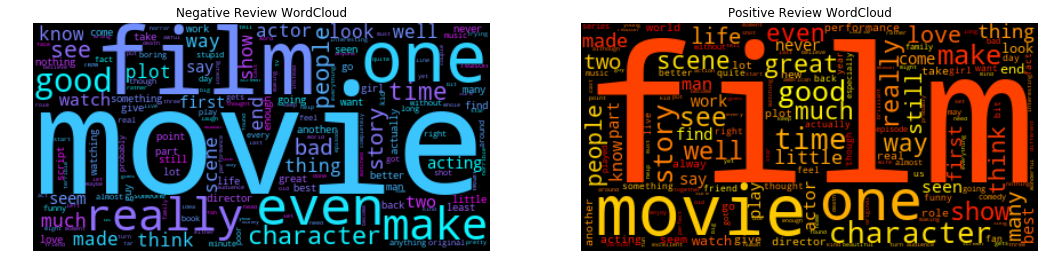

In [107]:
neg = cleaned_x_sw[cleaned_x_sw['label'] == 0]
neg_tweets = []
for i in neg['text']:
    neg_tweets.append(i.lower())
neg_tweets = pd.Series(neg_tweets).str.cat(sep=' ')

pos = cleaned_x_sw[cleaned_x_sw['label'] == 1]
pos_tweets = []
for i in pos['text']:
    pos_tweets.append(i.lower())
pos_tweets = pd.Series(pos_tweets).str.cat(sep=' ')

f,ax=plt.subplots(1,2,figsize=(18,6))
n_wordcloud = WordCloud(max_font_size=200, colormap = 'cool').generate(neg_tweets)
#plt.figure()
ax[0].imshow(n_wordcloud, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title('Negative Review WordCloud')

p_wordcloud = WordCloud(max_font_size=200, colormap='autumn').generate(pos_tweets)
#plt.figure()
ax[1].imshow(p_wordcloud, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title('Positive Review WordCloud')
plt.show()

Overall, the word clouds do not provide very helpful information. As many words occur frequently across both classes, this perhaps signals that a word embeddings should be used over bag of word methods in order to account for contextual data. 

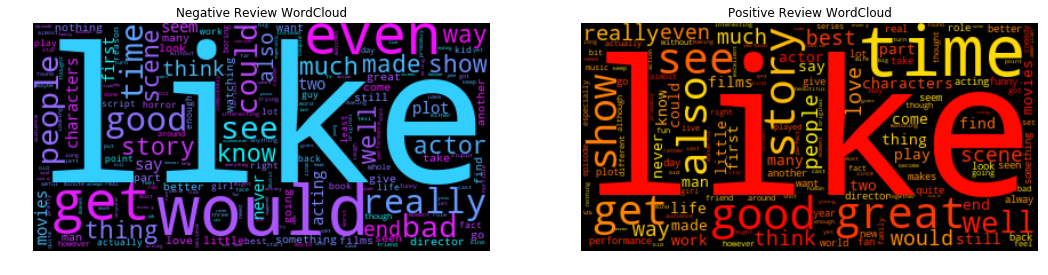

In [109]:
stopwords = set(['movie', 'film', 'character', 'watch', 'make', 'one'])

f,ax=plt.subplots(1,2,figsize=(18,6))
n_wordcloud = WordCloud(stopwords=stopwords, max_font_size=200, colormap = 'cool').generate(neg_tweets)
#plt.figure()
ax[0].imshow(n_wordcloud, interpolation="bilinear")
ax[0].axis("off")sed 
ax[0].set_title('Negative Review WordCloud')

p_wordcloud = WordCloud(stopwords=stopwords, max_font_size=200, colormap='autumn').generate(pos_tweets)
#plt.figure()
ax[1].imshow(p_wordcloud, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title('Positive Review WordCloud')
plt.show()

In order to make sure no data was leaked from the training to test data during the vectorization process, the sklearn Pipeline was used to split vectorizing and classification into 2 separate steps. Logistic Regression, SVM, and Naive Bayes have all shown strong performance even in comparison to deep learning results. The data set was split 70/30 between training and test. The training data was further split into 10 folds for cross validation

In [359]:
#Bag of Word Methods, lemmatized and stop words removed
vectorizer = [(CountVectorizer(), 'count'), (TfidfVectorizer(), 'tfidf')]
#clfs = [(LogisticRegression(), 'logistic_regression')]
clfs = [(LogisticRegression(), 'logistic_regression'), (MultinomialNB(), 'naive_bayes')
        , (SVC(), 'SVM_non_linear_kernel'),  (SVC(kernel = 'linear'), 'SVM_linear_kernel')]
combos = [(i, j) for i in vectorizer for j in clfs]

train, test = train_test_split(cleaned_x_sw_x_lem, test_size=0.3,stratify = cleaned_x_sw_x_lem['label'])
train_X = train['text']
train_Y = train['label']
test_X = test['text']
test_Y = test['label']
X = cleaned_x_sw_x_lem['text']
Y = cleaned_x_sw_x_lem['label']
pipeline = Pipeline([('vectorizer', CountVectorizer()), ('clf', LogisticRegression())])
 
accuracy = []
for i, j in combos:
    name = i[1] + '_' + j[1]
    pipeline.set_params(vectorizer = i[0], clf = j[0])
    scores = cross_validate(pipeline, X, Y, cv = 10)
    for v in scores['test_score']:
        accuracy.append((name, v))

Reviews vectorized by their frequency and classified using Logistic Regression as well as reviews vectorized by their tf-idf weights and classified with an SVM classifier w/ a linear kernel were the two strongest performers with accuracy scores of 84.8% and 85.6% respectively

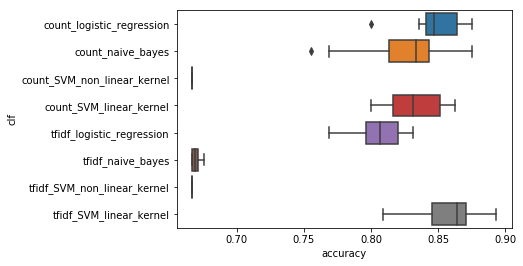

In [360]:
accuracy_df = pd.DataFrame(accuracy)
accuracy_df.columns = ['clf', 'accuracy']
sns.boxplot(x='accuracy', y = 'clf', data = accuracy_df)

In [361]:
accuracy_df.groupby('clf').mean()

,accuracy
clf,
count_SVM_linear_kernel,0.832889
count_SVM_non_linear_kernel,0.666667
count_logistic_regression,0.848444
count_naive_bayes,0.824000
tfidf_SVM_linear_kernel,0.856444
tfidf_SVM_non_linear_kernel,0.666667
tfidf_logistic_regression,0.806222
tfidf_naive_bayes,0.669778


In [177]:
pipeline = Pipeline([('vectorizer', CountVectorizer()), ('clf', LogisticRegression())])
param_grid = {'clf__C':[0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 10]}
gs = GridSearchCV(pipeline, param_grid, cv = 10)

gs.fit(train_X, train_Y)
predictions = gs.predict(test_X)

print(f'Accuracy: {gs.score(test_X, test_Y)}')
print(classification_report(test_Y, predictions))
print(f'Best hyperparam: {gs.best_params_}')

Accuracy: 0.845925925925926
              precision    recall  f1-score   support

           0       0.83      0.67      0.74       225
           1       0.85      0.93      0.89       450

   micro avg       0.85      0.85      0.85       675
   macro avg       0.84      0.80      0.82       675
weighted avg       0.84      0.85      0.84       675

Best hyperparam: {'clf__C': 0.4}


In [179]:
pipeline = Pipeline([('vectorizer', TfidfVectorizer()), ('clf', SVC(kernel = 'linear'))])
param_grid = {'clf__C':[0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 10]}
gs = GridSearchCV(pipeline, param_grid, cv = 10)

gs.fit(train_X, train_Y)
predictions = gs.predict(test_X)

print(f'Accuracy: {gs.score(test_X, test_Y)}')
print(classification_report(test_Y, predictions))
print(f'Best hyperparam: {gs.best_params_}')

Accuracy: 0.8518518518518519
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       225
           1       0.83      0.97      0.90       450

   micro avg       0.85      0.85      0.85       675
   macro avg       0.87      0.79      0.82       675
weighted avg       0.86      0.85      0.84       675

Best hyperparam: {'clf__C': 1}


Hyperparameter tuning was performed using the test data. SVM combined with the Tf-IDF vectorizer had the best accuracy and a nearly identical F1 score for classifying negative reviews

The following code is written to combine word embeddings to form a full review/document embedding. In order to investigate if a pretrained vs custom trained embedding would yield different performance, I trained a word2vec model on the review corpus and downloaded the pretrained GloVe twitter embeddings. I felt that twitter would be more similar to personal reviews and opinions than wikipedia. 

In [368]:
#word embeddings 
#pretrained vs custom trained 

class tfidf_model:

    def __init__(self, dataset, buzz_map, word_map = None, corpus = None):
        self.dataset = dataset
        self.buzz_map = buzz_map
        self.word_map = word_map
        if self.word_map == None:
            self.word_map = corpora.Dictionary(self.dataset)
        self.corpus = corpus
        if self.corpus == None:
            self.corpus = [self.word_map.doc2bow(i) for i in self.dataset]
        self.model = TfidfModel(self.corpus, id2word = self.word_map)
        self.transformed = self.model[self.corpus]

    def doc_tfidf(self, buzz_id, n):
        buzzmap = self.buzz_map
        wordmap = self.word_map
        tfidf = self.tfidf
        idx = buzzmap[buzz_id]
        a = sorted(tfidf[idx], key = lambda x: x[1], reverse = True)
        for i, j in a[:n]:
            print(i, wordmap[i], j)

        return
    
class Embeds:

    def __init__(self, data, buzz_map, tfidf, word_map, model):
        self.buzz_map = buzz_map
        self.tfidf_vecs = tfidf
        self.word_map = word_map
        self.model = model
        self.data = data

    def translate(self, text):
        translated = []
        wordmap = self.word_map
        for i, j in text:
            translated.append((wordmap[i], j))
        return translated

    def embed(self, id, append = False, obj = None):
        vec = []
        index = self.buzz_map[id]
        doctfidf = self.tfidf_vecs[index]
        newtfidf = self.translate(doctfidf)
        for i, j in newtfidf:
            try:
                vec.append(self.model[i] * j)
            except:
                pass
        vec = np.array(vec)
        weighted = np.sum(vec, axis = 0)
        if append:
            try:
                obj 
            except NameError:
                print('embeddings series does not exist')
                return
            else:
                if id in obj:
                    print('post already embedded')
                    return
                else:
                    obj.loc[id] = weighted
                    return
        return weighted
    
    def averaging(self, id):
        embedding = []
        text = self.data[id]
        text = [w for w in text.split()]
        for i in text:
            try:
                embedding.append(self.model[i])
            except:
                pass
        embedding = np.array(embedding)
        res = np.mean(embedding, axis = 0)
        return res
                

    def applymodel(self, embed_type = 'tfidf'):
        x = {}
        if embed_type == 'tfidf':
            for i, j in self.data.items():
                #print(j)
                x[i] = self.embed(i)
        else:
            for i, j in self.data.items():
                #print(j)
                x[i] = self.averaging(i)
        return pd.Series(x)
    
def update_train_w_test(test, mapping, word_map, train):
    testing = []
    for i, j in enumerate(test.items()):
        text = [w for w in j[1].lower().split()]
        testing.append(text)
        mapping.update({j[0]: len(train) + i})
    word_map.add_documents(testing)
    train.extend([word_map.doc2bow(i) for i in testing])
    tfidf_model = TfidfModel(train, id2word=word_map)
    tfidf = tfidf_model[train]
    return testing

In [369]:
review_mapping = {} #mapping of review to review id because the gensim tf-idf class does not maintain an id mapping
training = [] #reviews with words in list form for gensim formatting

for i, j in enumerate(train_X.items()):
    text = [w for w in j[1].lower().split()]
    training.append(text)
    review_mapping[j[0]] = i
    
tfidf = tfidf_model(training, review_mapping)

In [370]:
start_1 = time.time()

#skipgram, dimensionality of 300, downsampling of 0.001
wv = Word2Vec(training, min_count = 2, sample = 0.001, sg = 1, size = 300, window = 3, iter = 15, workers = 4)

print('model done, ' ,(time.time()- start_1)/60.0)

model done,  0.11102696657180786


In [219]:
#download pretrained glove vectors
glove = api.load("glove-twitter-100")

GloVe word embeddings seem to be more consistent than the embeddings generated from the training corpus. This is not unexpected as the size of the word2vec training corpus is very small

In [371]:
wv.most_similar('bad')

[('ugli', 0.6946163177490234),
 ('aw', 0.6856867671012878),
 ('btw', 0.6743755340576172),
 ('decent', 0.6682616472244263),
 ('measur', 0.6662102341651917),
 ('freddi', 0.6587079167366028),
 ('atroci', 0.6543193459510803),
 ('burst', 0.6420384049415588),
 ('horribl', 0.6407808661460876),
 ('alright', 0.6373760104179382)]

In [372]:
glove.most_similar('bad')

[('but', 0.8499987721443176),
 ('shit', 0.8407028913497925),
 ('really', 0.8376074433326721),
 ('way', 0.8303707838058472),
 ('thing', 0.8276875615119934),
 ("n't", 0.8259333968162537),
 ('right', 0.8235620856285095),
 ('stupid', 0.8233467936515808),
 ('think', 0.823115885257721),
 ('crazy', 0.8228102922439575)]

In [373]:
wv.most_similar('good')

[('decent', 0.717639684677124),
 ('dub', 0.7019113898277283),
 ('unconvinc', 0.6968963146209717),
 ('damn', 0.6841607093811035),
 ('ugli', 0.6819957494735718),
 ('paperhous', 0.6819354891777039),
 ('watchabl', 0.6796882152557373),
 ('meant', 0.6786888241767883),
 ('turner', 0.6771848797798157),
 ('restrain', 0.6771771907806396)]

In [374]:
glove.most_similar('good')

[('great', 0.8995508551597595),
 ('well', 0.8844854235649109),
 ('better', 0.8784540891647339),
 ('nice', 0.8719304800033569),
 ('too', 0.8506093621253967),
 ('night', 0.8455639481544495),
 ('way', 0.8432667255401611),
 ('but', 0.8425142168998718),
 ('it', 0.840853214263916),
 ('morning', 0.838019609451294)]

In [375]:
w2v = Embeds(train_X, review_mapping, tfidf.transformed, tfidf.word_map, wv)
gl = Embeds(train_X, review_mapping, tfidf.transformed, tfidf.word_map, glove)

In [376]:
wv_avg = w2v.applymodel(embed_type = 'avg')
wv_tfidf = w2v.applymodel()
glove_avg = gl.applymodel(embed_type = 'avg')
glove_tfidf = gl.applymodel()

In [377]:
testing = update_train_w_test(test_X, review_mapping, tfidf.word_map, tfidf.corpus)

In [378]:
wv.build_vocab(testing, update = True)
wv.train(testing, epochs=wv.iter, total_examples=wv.corpus_count)

(1055405, 1171950)

In [379]:
w2v_test = Embeds(test_X, review_mapping, tfidf.transformed, tfidf.word_map, wv)
gl_test = Embeds(test_X, review_mapping, tfidf.transformed, tfidf.word_map, glove)

In [380]:
wv_avg_test = w2v_test.applymodel(embed_type = 'avg')
wv_tfidf_test = w2v_test.applymodel()
glove_avg_test = gl_test.applymodel(embed_type = 'avg')
glove_tfidf_test = gl_test.applymodel()

In [381]:
def get_vectors(embeds, dataset, dim):
    vecs = np.zeros((len(dataset), dim))
    n = 0
    for i in dataset.keys():
        vecs[n] = embeds[i]
        n += 1
    return vecs

In [382]:
clf = LogisticRegression()

train_vecs = get_vectors(wv_tfidf, train_X, 300)
test_vecs = get_vectors(wv_tfidf_test, test_X, 300)

clf.fit(train_vecs,train_Y)
prediction=clf.predict(test_vecs)
model_probs = clf.predict_proba(test_vecs)[:, 1:]
model_auc_score = roc_auc_score(test_Y, model_probs)
print('accuracy: ', accuracy_score(prediction,test_Y))
print('auc: ', model_auc_score)

accuracy:  0.8014814814814815
auc:  0.8357728395061729


In [383]:
clf = LogisticRegression()

train_vecs = get_vectors(wv_avg, train_X, 300)
test_vecs = get_vectors(wv_avg_test, test_X, 300)

clf.fit(train_vecs,train_Y)
prediction=clf.predict(test_vecs)
model_probs = clf.predict_proba(test_vecs)[:, 1:]
model_auc_score = roc_auc_score(test_Y, model_probs)
print('accuracy: ', accuracy_score(prediction,test_Y))
print('auc: ', model_auc_score)

accuracy:  0.7555555555555555
auc:  0.8538567901234568


In [384]:
clf = LogisticRegression()

train_vecs = get_vectors(glove_tfidf, train_X, 100)
test_vecs = get_vectors(glove_tfidf_test, test_X, 100)

clf.fit(train_vecs,train_Y)
prediction=clf.predict(test_vecs)
model_probs = clf.predict_proba(test_vecs)[:, 1:]
model_auc_score = roc_auc_score(test_Y, model_probs)
print('accuracy: ', accuracy_score(prediction,test_Y))
print('auc: ', model_auc_score)

accuracy:  0.7511111111111111
auc:  0.7914172839506172


In [385]:
clf = LogisticRegression()

train_vecs = get_vectors(glove_avg, train_X, 100)
test_vecs = get_vectors(glove_avg_test, test_X, 100)

clf.fit(train_vecs,train_Y)
prediction=clf.predict(test_vecs)
model_probs = clf.predict_proba(test_vecs)[:, 1:]
model_auc_score = roc_auc_score(test_Y, model_probs)
print('accuracy: ', accuracy_score(prediction,test_Y))
print('auc: ', model_auc_score)

accuracy:  0.7614814814814815
auc:  0.818893827160494


In [386]:
clf = SVC(kernel = 'linear')

train_vecs = get_vectors(glove_avg, train_X, 100)
test_vecs = get_vectors(glove_avg_test, test_X, 100)

clf.fit(train_vecs,train_Y)
prediction=clf.predict(test_vecs)
print('accuracy: ', accuracy_score(prediction,test_Y))


accuracy:  0.7703703703703704


In [387]:
clf = SVC(kernel = 'linear')

train_vecs = get_vectors(glove_tfidf, train_X, 100)
test_vecs = get_vectors(glove_tfidf_test, test_X, 100)

clf.fit(train_vecs,train_Y)
prediction=clf.predict(test_vecs)
print('accuracy: ', accuracy_score(prediction,test_Y))

accuracy:  0.7511111111111111


In [388]:
clf = SVC(kernel = 'linear')

train_vecs = get_vectors(wv_tfidf, train_X, 300)
test_vecs = get_vectors(wv_tfidf_test, test_X, 300)

clf.fit(train_vecs,train_Y)
prediction=clf.predict(test_vecs)
print('accuracy: ', accuracy_score(prediction,test_Y))


accuracy:  0.7851851851851852


In [389]:
clf = SVC(kernel = 'linear')

train_vecs = get_vectors(wv_avg, train_X, 300)
test_vecs = get_vectors(wv_avg_test, test_X, 300)

clf.fit(train_vecs,train_Y)
prediction=clf.predict(test_vecs)
print('accuracy: ', accuracy_score(prediction,test_Y))

accuracy:  0.762962962962963


In [280]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import LSTM, Conv1D, Flatten, Dropout,Dense, GlobalMaxPooling1D,MaxPooling1D

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Convolution1D
from keras.callbacks import EarlyStopping

The Keras tokenizer was used to transform each review into a series of word ids

In [292]:
train, test =train_test_split(cleaned_x_sw,test_size=0.3,stratify=cleaned_x_sw['label'])
train_X = train['text']
train_Y = train['label']
test_X = test['text']
test_Y = test['label']
X = cleaned_x_sw['text']
Y = cleaned_x_sw['label']

docs = list(train_X.values)
labels = list(train_Y)

docs_test = list(test_X.values)
labels_test = list(test_Y)

In [345]:
#top_words = 5000
t = Tokenizer(num_words = top_words)
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
x_train = t.texts_to_sequences(docs)
x_test = t.texts_to_sequences(docs_test)

max_length = max([len(d) for d in x_train])

In [346]:
#padding sequences as Keras inputs must have the same shape
x_train_pad = pad_sequences(x_train, maxlen=max_length)
x_test_pad  = pad_sequences(x_test, maxlen=max_length)

In [347]:
embedding_matrix = np.zeros((vocab_size, 100))
for i, j in t.word_index.items():
    try:
        ev = glove[i]
        embedding_matrix[j] = ev
    except:
        pass

matches = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
matches / vocab_size #89% of vocabulary had a corresponding Glove Embedding

0.896102168418252

In [349]:
#LSTM 
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable = True)
model.add(e)
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 472, 100)          2255100   
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 101       
Total params: 2,335,601
Trainable params: 2,335,601
Non-trainable params: 0
_________________________________________________________________
None


In [350]:
batch_size = 64
num_epochs = 10

callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
             
x_val, y_val = x_train_pad[:batch_size], train_Y[:batch_size]
x_train2, y_train2 = x_train_pad[batch_size:], train_Y[batch_size:]
model.fit(x_train2, y_train2, validation_data=(x_val, y_val), callbacks=callbacks,  batch_size=batch_size, epochs=num_epochs)

Train on 1511 samples, validate on 64 samples
Epoch 1/10
1511/1511 [==============================] - 18s 12ms/step - loss: 0.5946 - acc: 0.6889 - val_loss: 0.4997 - val_acc: 0.7812
Epoch 2/10
1511/1511 [==============================] - 14s 9ms/step - loss: 0.4830 - acc: 0.7704 - val_loss: 0.4175 - val_acc: 0.8281
Epoch 3/10
1511/1511 [==============================] - 13s 9ms/step - loss: 0.3973 - acc: 0.8259 - val_loss: 0.3803 - val_acc: 0.8438
Epoch 4/10
1511/1511 [==============================] - 14s 9ms/step - loss: 0.3117 - acc: 0.8795 - val_loss: 0.3609 - val_acc: 0.8438
Epoch 5/10
1511/1511 [==============================] - 12s 8ms/step - loss: 0.2286 - acc: 0.9193 - val_loss: 0.3584 - val_acc: 0.7969
Epoch 6/10
1511/1511 [==============================] - 12s 8ms/step - loss: 0.1678 - acc: 0.9437 - val_loss: 0.4503 - val_acc: 0.8281
Epoch 7/10
1511/1511 [==============================] - 12s 8ms/step - loss: 0.1198 - acc: 0.9603 - val_loss: 0.3732 - val_acc: 0.8125


In [351]:
model.evaluate(x_test_pad, test_Y, verbose=1)

675/675 [==============================] - 2s 3ms/step


[0.4548361523946126, 0.8340740741623772]

In [352]:
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)
model.add(e)
#model.add(Convolution1D(256, 5, border_mode='same'))
model.add(Convolution1D(128, 3, border_mode='same'))
#model.add(Dense(64, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 472, 100)          2255100   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 472, 128)          38528     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 129       
Total params: 2,293,757
Trainable params: 2,293,757
Non-trainable params: 0
_________________________________________________________________
None


In [353]:
batch_size = 64
num_epochs = 10

callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
             
x_val, y_val = x_train_pad[:batch_size], train_Y[:batch_size]
x_train2, y_train2 = x_train_pad[batch_size:], train_Y[batch_size:]
model.fit(x_train2, y_train2, validation_data=(x_val, y_val), callbacks=callbacks,  batch_size=batch_size, epochs=num_epochs)

Train on 1511 samples, validate on 64 samples
Epoch 1/10
1511/1511 [==============================] - 6s 4ms/step - loss: 0.6064 - acc: 0.6817 - val_loss: 0.5674 - val_acc: 0.7344
Epoch 2/10
1511/1511 [==============================] - 5s 3ms/step - loss: 0.4428 - acc: 0.8405 - val_loss: 0.5083 - val_acc: 0.7344
Epoch 3/10
1511/1511 [==============================] - 5s 3ms/step - loss: 0.3423 - acc: 0.9001 - val_loss: 0.4761 - val_acc: 0.7656
Epoch 4/10
1511/1511 [==============================] - 5s 3ms/step - loss: 0.2636 - acc: 0.9596 - val_loss: 0.4682 - val_acc: 0.7812
Epoch 5/10
1511/1511 [==============================] - 5s 3ms/step - loss: 0.2027 - acc: 0.9788 - val_loss: 0.4394 - val_acc: 0.7812
Epoch 6/10
1511/1511 [==============================] - 5s 3ms/step - loss: 0.1535 - acc: 0.9954 - val_loss: 0.4267 - val_acc: 0.7812
Epoch 7/10
1511/1511 [==============================] - 5s 3ms/step - loss: 0.1171 - acc: 0.9993 - val_loss: 0.4184 - val_acc: 0.7812
Epoch 8/10
1511/

In [354]:
model.evaluate(x_test_pad, test_Y, verbose=1)

675/675 [==============================] - 1s 913us/step


[0.38551963435278996, 0.8311111111552627]